In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Tuition Data from IPEDS

Student Charges: What is the average amount of tuition and required fees for full-time undergraduate students at private postsecondary institutions operating on an academic year calendar system?

In academic year 2023-24, the average amount of tuition and required fees for full-time undergraduate students at private postsecondary institutions operating on an academic year calendar system was $28,529. This is based on 1,956 institutions, limited by Institutional category and Degree-granting status.*

In [10]:
def clean_year(value):
   value = str(value)
   clean_value = value.split("-")[0] 
   clean_value = pd.to_datetime(clean_value, format="%Y")
   return clean_value

def clean_numeric(series):
    series = series.astype(str)

    series = series.replace(r"[^0-9.]", "", regex=True)

    return pd.to_numeric(series, errors="coerce")

In [11]:
private_non_degree_df = pd.read_csv('../data/tuition_summary.csv')
private_non_degree_df = private_non_degree_df.rename(columns={"Average amount (in USD)":"Average Tuition & Feeds"})
private_non_degree_df['degree_granting'] = False

private_degree_df = pd.read_csv('../data/degree_granting_tuition_summary.csv', skiprows=4, nrows=22)
private_degree_df = private_degree_df.rename(columns={"Average amount (in USD)":"Average Tuition & Feeds"})
private_degree_df['degree_granting'] = True

private_combined = pd.concat([private_degree_df, private_non_degree_df])

private_combined['Year Parsed'] = private_combined['Academic Year'].apply(clean_year)

private_combined["Average Tuition & Feeds"] = clean_numeric(private_combined["Average Tuition & Feeds"])

private_combined = private_combined.sort_values('Year Parsed',ascending=True)

In [12]:
limited_private_df = private_combined[private_combined['Year Parsed'] >= '2019-01-01']

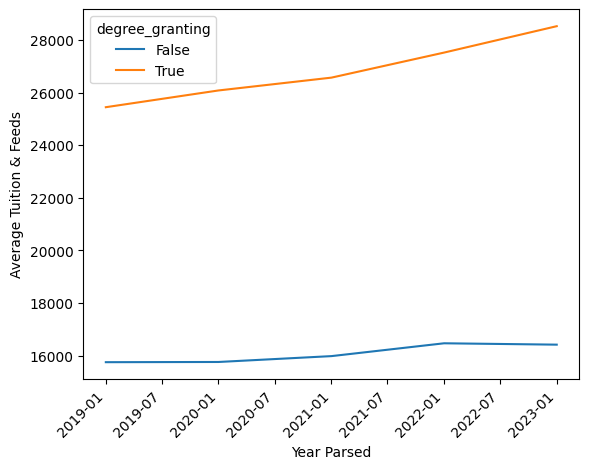

In [13]:
ax = sns.lineplot(
    data=limited_private_df,
    x='Year Parsed',
    y='Average Tuition & Feeds',
    hue='degree_granting'
)

plt.xticks(rotation=45, ha='right')
plt.show()

## Financial Aid
This table presents data collected from Title IV institutions in the United States. Prior to 2009-10, the data include only Title IV primarily postsecondary institutions."

"Prior to academic year 2010-11, the data represents students receiving aid, rather than students awarded aid. Students awarded aid include those who were awarded aid and accepted while student receiving aid include those who were awarded and disbursed aid"
"SOURCE: U.S. Department of Education, National Center for Education Statistics, Integrated Postsecondary Education Data System (IPEDS), Student Financial Aid component final data (2001-02 - 2021-22) and provisional data (2022-23).

In [14]:
aid_df = pd.read_csv('../data/financial_aid.csv',skiprows=3, nrows=22)

aid_df["Year Parsed"] = aid_df["Year"].apply(clean_year)

aid_df.rename(columns={"Non-degree-granting, primarily postsecondary":"Non-degree granting"}, 
              inplace=True)

aid_df = pd.melt(aid_df, id_vars=['Year Parsed'], value_vars=['Degree-granting',
       'Non-degree granting'])

aid_df["value"] = clean_numeric(aid_df["value"])

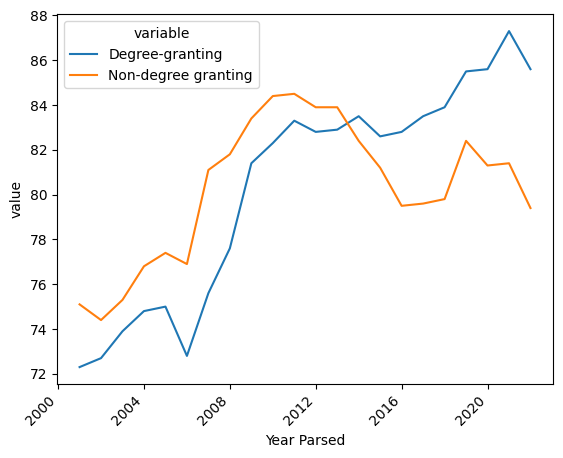

In [15]:
ax = sns.lineplot(
    data=aid_df,
    x='Year Parsed',
    y='value',
    hue='variable'
)

plt.xticks(rotation=45, ha='right', minor=False)
plt.yticks()
plt.show()

### FRED Data

In [16]:
import json

with open('/Users/Emi/api_keys.json','r') as f:
    api_keys = json.load(f)
    FRED_API_KEY = api_keys.get('fred')

In [17]:
import os
from fredapi import Fred

fred = Fred(api_key=FRED_API_KEY)

In [18]:
def fetch_series(series_ids, freq_label):
    """
    Download multiple FRED series into a single DataFrame.
    
    Parameters
    ----------
    series_ids : dict
        Mapping of column name -> FRED series ID.
    freq_label : str
        A short label like 'monthly' or 'quarterly' (used only for column naming if you want).
    """
    data = {}
    for col_name, sid in series_ids.items():
        s = fred.get_series(sid)          # pandas Series indexed by date
        s.name = col_name
        data[col_name] = s

    df = pd.concat(data.values(), axis=1)
    df.index.name = "date"
    return df


In [ ]:
monthly_ids = {
    # unemployment rate (percent) 25 years and older
    # "unemp_ba_plus": "LNS14027662", #bachelors or higher
    "unemp_some_college_assoc": "LNS14027689", #
    "unemp_ba_only":"CGBD25O", #bachelors
    "unemp_hs":"LNS14027660",

    # employment-population ratio (percent) 25 years and older
    "emp_pop_ba_plus": "LNS12327662",
    "emp_pop_some_college_assoc": "LNS12327689",
    "emp_high_school":"LNS12327660"
}

quarterly_ids = {
    "ba_med_weekly_earnings":"LEU0252919100Q",
    "some_college_assoc_med_weekly_earnings":"LEU0254929400Q",
    "high_school_med_weekly_earnings":"LEU0252917300Q"
}

monthly_df = fetch_series(monthly_ids, freq_label="monthly")
monthly_df = monthly_df.reset_index()
monthly_df = monthly_df[monthly_df['date'] >= '2019-01-01']

quarterly_df = fetch_series(quarterly_ids, freq_label="quarterly")
quarterly_df = quarterly_df.reset_index()
quarterly_df = quarterly_df[quarterly_df['date'] >= '2019-01-01']


In [42]:
melted_monthly_unemp_df = pd.melt(monthly_df, id_vars=['date'], value_vars=['unemp_some_college_assoc', 'unemp_ba_only', 'unemp_hs'])
melted_monthly_unemp_df.head()

,date,variable,value
0,2019-01-01,unemp_some_college_assoc,3.5
1,2019-02-01,unemp_some_college_assoc,3.2
2,2019-03-01,unemp_some_college_assoc,3.4
3,2019-04-01,unemp_some_college_assoc,3.1
4,2019-05-01,unemp_some_college_assoc,2.7


In [44]:
melted_monthly_emp_ratio_df = pd.melt(monthly_df, id_vars=['date'], value_vars=['emp_pop_ba_plus', 'emp_pop_some_college_assoc', 'emp_high_school'])
melted_monthly_emp_ratio_df.head()

,date,variable,value
0,2019-01-01,emp_pop_ba_plus,72.1
1,2019-02-01,emp_pop_ba_plus,72.1
2,2019-03-01,emp_pop_ba_plus,72.2
3,2019-04-01,emp_pop_ba_plus,72.3
4,2019-05-01,emp_pop_ba_plus,72.2


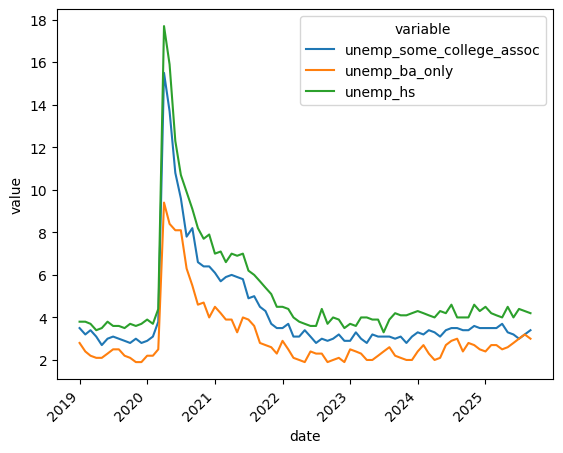

In [ ]:
ax = sns.lineplot(
    data= melted_monthly_df,
    x='date',
    y='value',
    hue='variable'
)

plt.xticks(rotation=45, ha='right', minor=False)
plt.yticks()
plt.show()

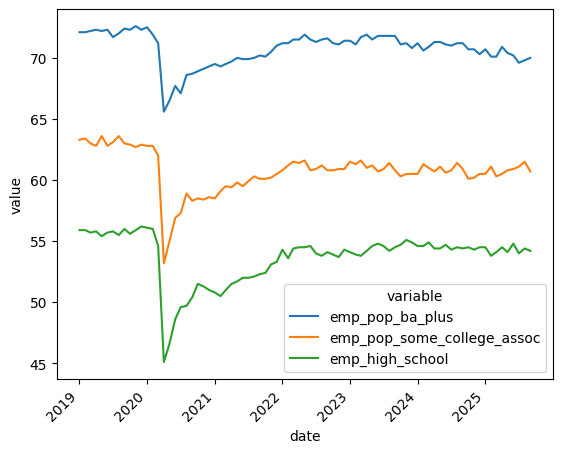

In [45]:
ax = sns.lineplot(
    data= melted_monthly_emp_ratio_df,
    x='date',
    y='value',
    hue='variable'
)

plt.xticks(rotation=45, ha='right', minor=False)
plt.yticks()
plt.show()